# Distraction Driver Detection Project

> In this notebook, I'll use the dataset which includes images of drivers while performing a number of tasks including drinking, texting etc. The aim is to correctly identify if the driver is distracted from driving. We might also like to check what activity the person is performing.

The notebook will be borken into the following steps:

0. Import the Libraries.
1. Import the Datasets.
2. Create a vanilla CNN model.
3. Create a vanilla CNN model with data augmentation.
4. Train a CNN with Transfer Learning (VGG16).
5. Kaggle Results.


## Import the Libraries

I'll use Keras and Tensorflow libraries to create a **Convolutional Neural Network**. So, I'll import the necessary libraries to do the same.

In [1]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


## Import the Datasets

I'll import the `.csv` file to read the labels.

In [2]:
dataset = pd.read_csv('../input/driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


From the csv file, I'll use the `classname` as the labels for the images and use the image names to match the labels with the correct images.

#### Import Driver Dataset

In [3]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In the following, I prepare the code to import the dataset of the driver images. then populate a few variables.

In [4]:
# Load the dataset previously downloaded from Kaggle
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('..', 'input', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('..', 'input', 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [5]:
img_rows = 64
img_cols = 64
color_type = 1

In [6]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:09<01:21,  9.08s/it]

Loading directory c1


 20%|██        | 2/10 [00:18<01:13,  9.13s/it]

Loading directory c2


 30%|███       | 3/10 [00:27<01:03,  9.02s/it]

Loading directory c3


 40%|████      | 4/10 [00:35<00:53,  8.94s/it]

Loading directory c4


 50%|█████     | 5/10 [00:44<00:44,  8.87s/it]

Loading directory c5


 60%|██████    | 6/10 [00:53<00:35,  8.82s/it]

Loading directory c6


 70%|███████   | 7/10 [01:01<00:26,  8.79s/it]

Loading directory c7


 80%|████████  | 8/10 [01:09<00:16,  8.47s/it]

Loading directory c8


 90%|█████████ | 9/10 [01:16<00:08,  8.05s/it]

Loading directory c9


100%|██████████| 10/10 [01:24<00:00,  8.05s/it]

Data Loaded in 84.80669832229614 second
Train shape: (17939, 64, 64, 1)
17939 train samples


In [7]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|          | 184/79726 [00:00<05:06, 259.53it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


#### Statistics

In [8]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob("../input/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('..', 'input', 'test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


#### Dataset Visualization

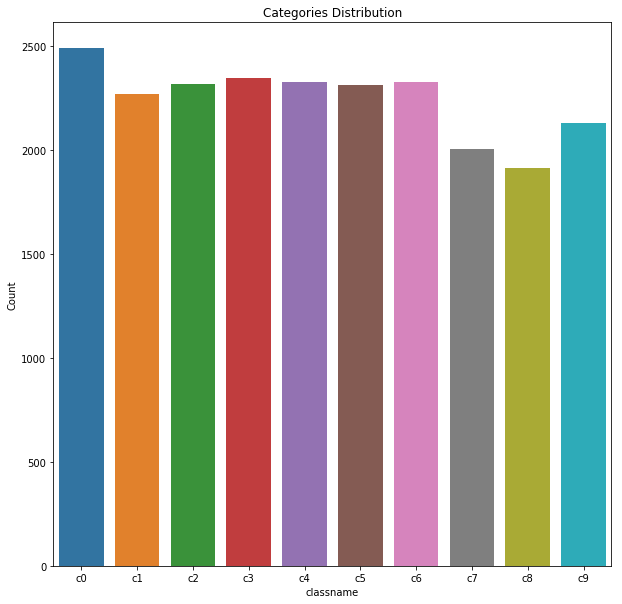

In [9]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [10]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 1440x1440 with 0 Axes>

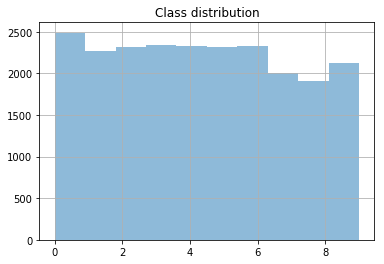

In [11]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

#### Images overview

Let's take a look at the various images in the dataset. I'll plot an image for each of the 10 classes. As the directory names are not descriptive, I'll use a map to define the title for each image that is more descriptive.

In [12]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

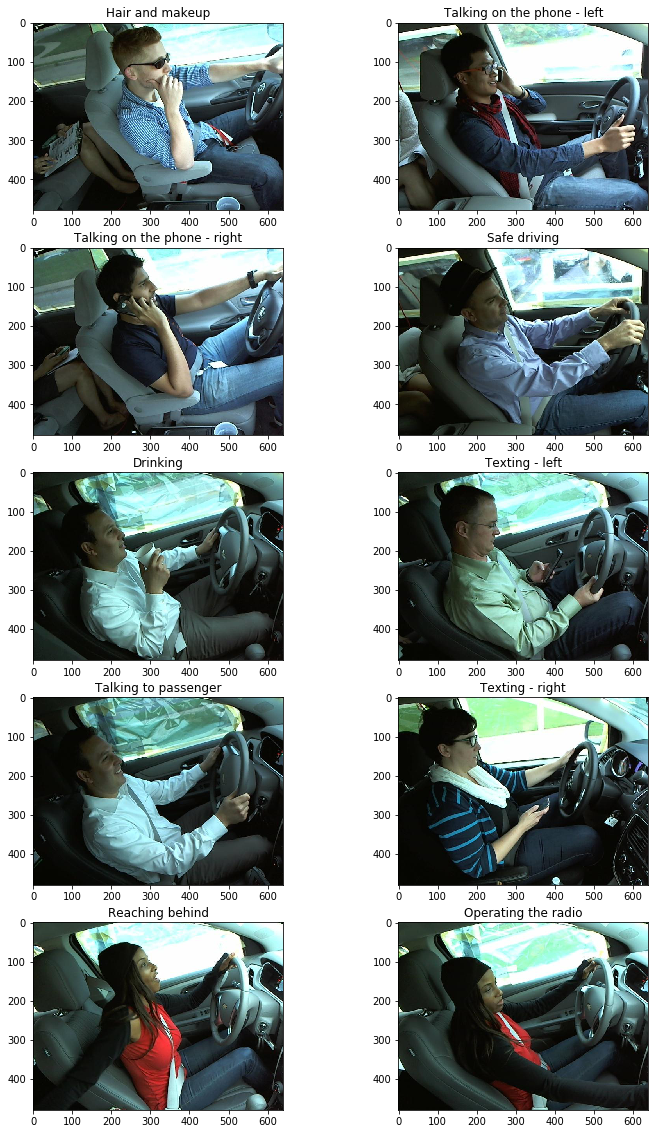

In [13]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '../input/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [14]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

## Create a vanilla CNN model

#### Building the model

I'll develop the model with a total of 4 Convolutional layers, then a Flatten layer and then 2 Dense layers. I'll use the optimizer as `rmsprop`, and loss as `categorical_crossentropy`.

In [15]:
batch_size = 40
nb_epoch = 10

In [16]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [17]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

#### Model v1
---

In [18]:
def create_model_v1():
    # Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [19]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 512)         1180160   
__________

In [20]:
# Training the Vanilla Model version 1
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17939/17939 [==============================] - 13s 711us/step - loss: 14.3317 - acc: 0.1106 - val_loss: 14.4542 - val_acc: 0.1032

Epoch 00001: val_loss improved from inf to 14.45418, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/10
17939/17939 [==============================] - 6s 338us/step - loss: 14.2977 - acc: 0.1129 - val_loss: 14.4542 - val_acc: 0.1032

Epoch 00002: val_loss did not improve from 14.45418
Epoch 3/10
17939/17939 [==============================] - 6s 338us/step - loss: 14.2977 - acc: 0.1129 - val_loss: 14.4542 - val_acc: 0.1032

Epoch 00003: val_loss did not improve from 14.45418
Epoch 00003: early stopping


Load the classifier with the best validation loss

In [21]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

In [22]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

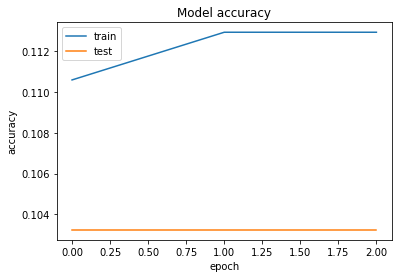

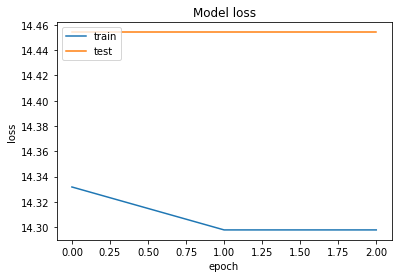

In [23]:
plot_train_history(history_v1)

In [24]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [25]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

4485/4485 [==============================] - 0s 111us/step
Score:  [14.454175871271753, 0.1032329988851728]


1/1 [==============================] - 0s 85ms/step
Y prediction: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Predicted: Safe driving


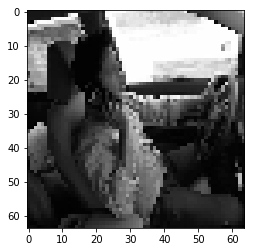

In [26]:
plot_test_class(model_v1, test_files, 20)

In [27]:
!rm -f saved_models/weights_best_vanilla.hdf5

#### Optimised Vanilla CNN Model 

#### Model v2
---

In [28]:
def create_model_v2():
    # Optimised Vanilla CNN model
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [29]:
model_v2 = create_model_v2()

# More details about the layers
model_v2.summary()

# Compiling the model
model_v2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 64)        18496     
__________

In [30]:
# Training the Vanilla Model
history_v2 = model_v2.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17939/17939 [==============================] - 11s 601us/step - loss: 1.2836 - acc: 0.5832 - val_loss: 0.3897 - val_acc: 0.8892

Epoch 00001: val_loss improved from 14.45418 to 0.38968, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/10
17939/17939 [==============================] - 9s 485us/step - loss: 0.3398 - acc: 0.8895 - val_loss: 0.1691 - val_acc: 0.9541

Epoch 00002: val_loss improved from 0.38968 to 0.16910, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 3/10
17939/17939 [==============================] - 9s 482us/step - loss: 0.2045 - acc: 0.9375 - val_loss: 0.1461 - val_acc: 0.9592

Epoch 00003: val_loss improved from 0.16910 to 0.14608, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 4/10
17939/17939 [==============================] - 9s 482us/step - loss: 0.1539 - acc: 0.9542 - val_loss: 0.0804 - val_acc: 0.9773

Epoch 00004: val_loss improved from 0.14608 to 0.08040, savi

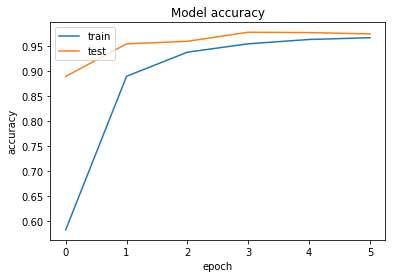

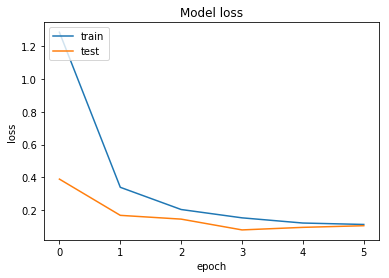

In [31]:
plot_train_history(history_v2)

In [32]:
model_v2.load_weights('saved_models/weights_best_vanilla.hdf5')

In [33]:
score = model_v2.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

y_pred = model_v2.predict(x_test, batch_size=batch_size, verbose=1)
score = log_loss(y_test, y_pred)
print('Score log loss:', score)

4485/4485 [==============================] - 1s 169us/step
Score:  [0.08040025654656931, 0.9772575250969018]
4485/4485 [==============================] - 1s 202us/step
Score log loss: 0.08114729752731625


1/1 [==============================] - 0s 16ms/step
Y prediction: [[4.9299712e-07 1.4429716e-06 3.8519315e-07 1.9566501e-06 4.8456100e-06
  5.2183154e-06 2.0294858e-06 9.9994361e-01 3.9229144e-05 8.5255414e-07]]
Predicted: Reaching behind


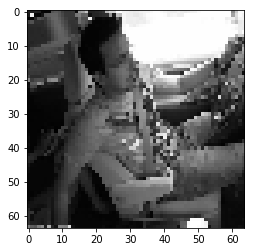

In [34]:
plot_test_class(model_v2, test_files, 101) # The model really performs badly

1/1 [==============================] - 0s 3ms/step
Y prediction: [[3.02609569e-11 5.60016061e-19 1.04951575e-14 1.91982423e-14
  1.89605845e-13 1.00000000e+00 1.68473037e-13 4.72590016e-16
  1.23049398e-13 3.37126743e-10]]
Predicted: Operating the radio


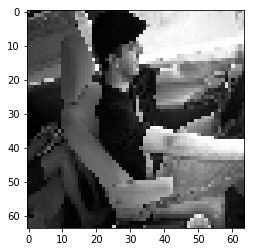

In [35]:
plot_test_class(model_v2, test_files, 1) # The model really performs badly

1/1 [==============================] - 0s 4ms/step
Y prediction: [[3.1209636e-11 3.9692014e-11 1.2535137e-18 1.0000000e+00 1.4814941e-15
  8.2983318e-15 3.4261839e-19 2.1233931e-19 2.7101924e-17 3.3722105e-15]]
Predicted: Texting - left


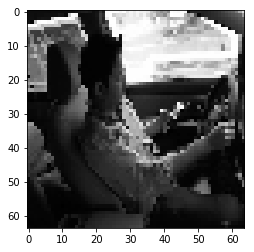

In [36]:
plot_test_class(model_v2, test_files, 143) 

## Create a vanilla CNN model with data augmentation

Here I'm augmenting the previous model `classifier`, I'll use the data on which I want to train the model. The folder `train` includes the images I need. I'll generate more images using **ImageDataGenerator** and split the training data into 80% train and 20% validation split.

In [37]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [38]:
# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [39]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
print(nb_train_samples)
print(nb_validation_samples)
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

17939
4485


#### Train the model with Data Augmentation

Using `fit_generator`, I'll train the model.

In [40]:
checkpoint = ModelCheckpoint('saved_models/weights_best_vanilla.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v3 = model_v2.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
448/448 [==============================] - 11s 25ms/step - loss: 1.2190 - acc: 0.6296 - val_loss: 14.2814 - val_acc: 0.0871

Epoch 00001: val_acc improved from -inf to 0.08705, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/5
448/448 [==============================] - 11s 25ms/step - loss: 0.6800 - acc: 0.7784 - val_loss: 0.4412 - val_acc: 0.8432

Epoch 00002: val_acc improved from 0.08705 to 0.84319, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 3/5
448/448 [==============================] - 11s 25ms/step - loss: 0.5077 - acc: 0.8339 - val_loss: 0.1343 - val_acc: 0.9705

Epoch 00003: val_acc improved from 0.84319 to 0.97053, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 4/5
448/448 [==============================] - 12s 27ms/step - loss: 0.4367 - acc: 0.8646 - val_loss: 0.1589 - val_acc: 0.9593

Epoch 00004: val_acc did not improve from 0.97053
Epoch 5/5
448/448 [==============================] - 11s 25ms/step - loss: 0.3831 - ac

In [41]:
model_v2.load_weights('saved_models/weights_best_vanilla.hdf5')

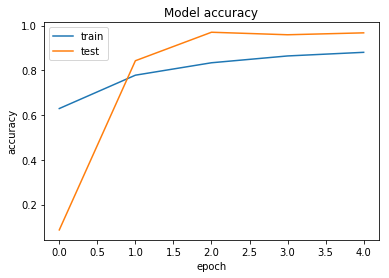

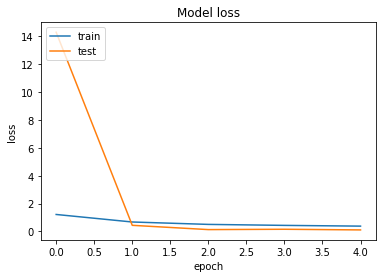

In [42]:
plot_train_history(history_v3)

In [43]:
# Evaluate the performance of the new model
score = model_v2.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.12765674600382917
Test Accuracy: 0.9696288023005722


1/1 [==============================] - 0s 2ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


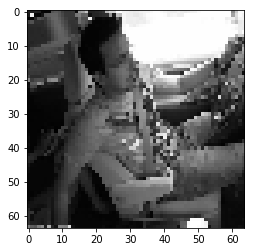

In [44]:
plot_test_class(model_v2, test_files, 101)

1/1 [==============================] - 0s 2ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


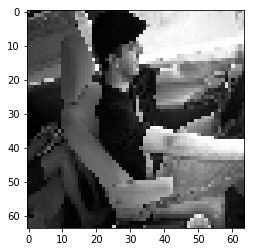

In [45]:
plot_test_class(model_v2, test_files, 1) 

1/1 [==============================] - 0s 3ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


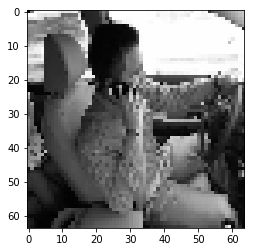

In [46]:
plot_test_class(model_v2, test_files, 145) 

1/1 [==============================] - 0s 3ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


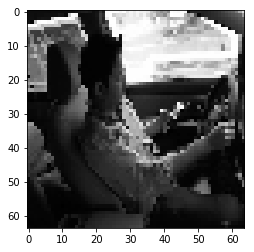

In [47]:
plot_test_class(model_v2, test_files, 143) 

In [48]:
predictions = model_v2.predict(test_files, batch_size=batch_size)
FileLink(create_submission(predictions, test_targets, score[0]))

/kaggle/working/kaggle_submissions/submission_0.12765674600382917_2019-07-14-16-10.csv

The trained model achieved a validation accuracy of over 93%.

In [49]:
!rm -f saved_models/weights_best_vanilla.hdf5

## Train a CNN with Transfer Learning (VGG, MobileNet)

To reduce training time without sacrificing accuracy, I'll train a CNN using **transfer learning**.

In [50]:
def vgg_std16_model(img_rows, img_cols, color_type=3):
    nb_classes = 10
    # Remove fully connected layer and replace
    # with softmax for classifying 10 classes
    vgg16_model = VGG16(weights="imagenet", include_top=False)

    # Freeze all layers of the pre-trained model
    for layer in vgg16_model.layers:
        layer.trainable = False
        
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation = 'softmax')(x)

    model = Model(input = vgg16_model.input, output = predictions)
    
    return model

In [51]:
# Load the VGG16 network
print("Loading network...")
model_vgg16 = vgg_std16_model(img_rows, img_cols)

model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

Loading network...
58892288/58889256 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
__________________________________________________________

In [52]:
training_generator = train_datagen.flow_from_directory('../input/train', 
                                                 target_size = (img_rows, img_cols), 
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")

validation_generator = test_datagen.flow_from_directory('../input/train', 
                                                   target_size = (img_rows, img_cols), 
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")
nb_train_samples = 17943
nb_validation_samples = 4481

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [53]:
!rm -f saved_models/weights_best_vgg16.hdf5

In [54]:
# Training the Vanilla Model
checkpoint = ModelCheckpoint('saved_models/weights_best_vgg16.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v4 = model_vgg16.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         class_weight='auto',
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
448/448 [==============================] - 132s 294ms/step - loss: 1.6557 - acc: 0.4076 - val_loss: 1.1794 - val_acc: 0.5786

Epoch 00001: val_acc improved from -inf to 0.57857, saving model to saved_models/weights_best_vgg16.hdf5
Epoch 2/5
448/448 [==============================] - 126s 282ms/step - loss: 1.1881 - acc: 0.5873 - val_loss: 0.9489 - val_acc: 0.6794

Epoch 00002: val_acc improved from 0.57857 to 0.67935, saving model to saved_models/weights_best_vgg16.hdf5
Epoch 3/5
448/448 [==============================] - 128s 285ms/step - loss: 0.9762 - acc: 0.6670 - val_loss: 0.7854 - val_acc: 0.7208

Epoch 00003: val_acc improved from 0.67935 to 0.72078, saving model to saved_models/weights_best_vgg16.hdf5
Epoch 4/5
448/448 [==============================] - 127s 283ms/step - loss: 0.8440 - acc: 0.7115 - val_loss: 0.8239 - val_acc: 0.6987

Epoch 00004: val_acc did not improve from 0.72078
Epoch 5/5
448/448 [==============================] - 129s 289ms/step - loss: 0.7203 -

In [55]:
model_vgg16.load_weights('saved_models/weights_best_vgg16.hdf5')

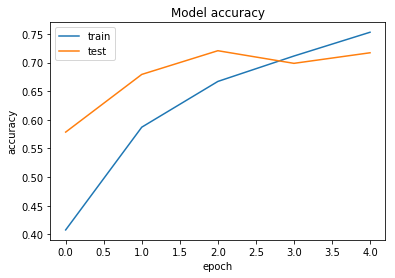

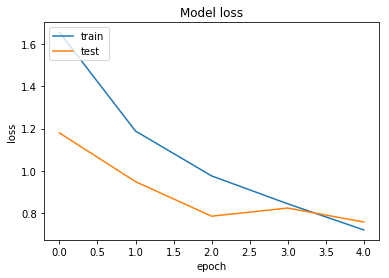

In [56]:
plot_train_history(history_v4)

In [57]:
def plot_vgg16_test_class(model, test_files, image_number):
    img_brute = test_files[image_number]

    im = cv2.resize(cv2.cvtColor(img_brute, cv2.COLOR_BGR2RGB), (img_rows,img_cols)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)

    img_display = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_display, cmap='gray')

    y_preds = model.predict(im, batch_size=batch_size, verbose=1)
    print(y_preds)
    y_prediction = np.argmax(y_preds)
    print('Y Prediction: {}'.format(y_prediction))
    print('Predicted as: {}'.format(activity_map.get('c{}'.format(y_prediction))))
    
    plt.show()

1/1 [==============================] - 0s 191ms/step
[[0.00347924 0.00235305 0.11284201 0.3124336  0.19840163 0.02728708
  0.2268958  0.00240693 0.00848995 0.10541063]]
Y Prediction: 3
Predicted as: Texting - left


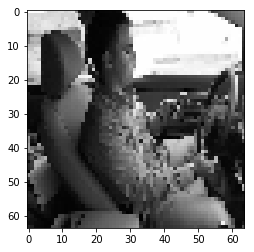

In [58]:
plot_vgg16_test_class(model_vgg16, test_files, 133) # Texting left

1/1 [==============================] - 0s 4ms/step
[[3.7002992e-02 1.1668080e-03 2.5999082e-02 8.3198383e-02 3.6355081e-01
  7.1047834e-04 1.0933013e-02 1.9789676e-04 4.0122531e-03 4.7322834e-01]]
Y Prediction: 9
Predicted as: Talking to passenger


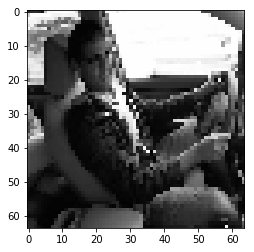

In [59]:
plot_vgg16_test_class(model_vgg16, test_files, 29) # Texting left

1/1 [==============================] - 0s 4ms/step
[[0.04419658 0.00090893 0.00150596 0.00311125 0.13353273 0.2725955
  0.18255351 0.00088873 0.2000806  0.16062628]]
Y Prediction: 5
Predicted as: Operating the radio


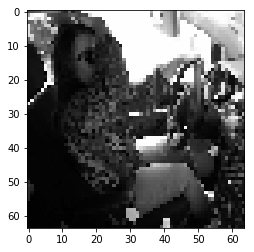

In [60]:
plot_vgg16_test_class(model_vgg16, test_files, 82) # Hair

In [61]:
# Evaluate the performance of the new model
score = model_vgg16.evaluate_generator(validation_generator, nb_validation_samples // batch_size, verbose = 1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

112/112 [==============================] - 21s 186ms/step
Test Score: 0.7813238947744763
Test Accuracy: 0.7225850027333882
